In [1]:
import matplotlib.pyplot as plt
# import dataprep # this not working
import pandas as pd
import numpy as np
# Import the data
# signal_data = pd.read_hdf("/dice/projects/CMS/Hinv/datasets_for_ml_training/ttH/df_ml_inputs.hd5")
# background_data = pd.read_hdf("/dice/projects/CMS/Hinv/datasets_for_ml_training/ttBar/df_ml_inputs.hd5")

signal_data = pd.read_parquet("/dice/projects/CMS/Hinv/ml_datasets_ULRun2_250312_hadronic/ml_inputs_UL2018/ttH_HToInvisible_M125")
semi_data = pd.read_parquet("/dice/projects/CMS/Hinv/ml_datasets_ULRun2_250312_hadronic/ml_inputs_UL2018/TTToSemiLeptonic")
hadronic_data = pd.read_parquet("/dice/projects/CMS/Hinv/ml_datasets_ULRun2_250312_hadronic/ml_inputs_UL2018/TTToHadronic.parquet")
di_data = pd.read_parquet("/dice/projects/CMS/Hinv/ml_datasets_ULRun2_250312_hadronic/ml_inputs_UL2018/TTTo2L2Nu.parquet")

In [2]:
import pandas as pd
import numpy as np

def prep(signal_data, semi_data, hadronic_data, di_data):
    # Combine datasets & assign target labels
    signal_data['target'] = 1
    semi_data['target'] = 0
    hadronic_data['target'] = 0
    di_data['target'] = 0

    # Merge all data
    data = pd.concat([signal_data, semi_data, hadronic_data, di_data], ignore_index=True)

    # # Data cleaning
    # data = data.dropna()
    # data = data[~data.region.isin([1, 2, 3, 4, 5])]
    # data = data[data['weight_nominal'] >= 0]

    # print('computing weights')
    # # Compute total weights for signal and background
    # total_signal_weight = data.loc[data['target'] == 1, 'weight_nominal'].sum()
    # total_background_weight = data.loc[data['target'] == 0, 'weight_nominal'].sum()

    # # Assign class balance weighting
    # data.loc[data['target'] == 1, 'weight_balance'] = total_signal_weight / total_background_weight
    # data.loc[data['target'] == 0, 'weight_balance'] = total_background_weight / total_signal_weight

    # print('adding features')
    # # Compute additional features from jet data
    # data['cleanedJet_eta_std'] = data['cleanedJet_eta'].apply(np.std)
    # data['cleanedJet_eta_range'] = data['cleanedJet_eta'].apply(lambda x: np.max(x) - np.min(x))
    # data['cleanedJet_phi_std'] = data['cleanedJet_phi'].apply(np.std)
    # data['cleanedJet_phi_range'] = data['cleanedJet_phi'].apply(lambda x: np.max(x) - np.min(x))

    return data


In [3]:
df = prep(signal_data, hadronic_data, semi_data, di_data)

In [4]:
import os 
import sys
import torch

# Personal scripts #
path_src = './src'
if path_src not in sys.path:
    sys.path.insert(0,path_src)

path = '/home/pk21271/prep_data/mlp_binary_raw'

df.to_parquet(os.path.join(path, 'df.parquet'))


In [ ]:
import torch
import os

# Convert DataFrame to a dictionary of tensors
df_tensors = {col: torch.tensor(df[col].values, dtype=torch.float32) for col in df.columns}

# Save efficiently as a PyTorch file
torch.save(df_tensors, os.path.join(path, 'df_tensors.pt'))


In [5]:
# List of variables to use for training
features = ['DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi',
       'MinOmegaHat', 'MinOmegaTilde', 'cleanedJet_eta_std', 'cleanedJet_eta_range',
       'cleanedJet_phi_range', 'cleanedJet_phi_std', 'ldphi_bjet',
       'ldphi_jet', 'ncleanedBJet', 'ncleanedJet', 'region', 'sdphi_bjet',
       'sdphi_jet']


weights_copy = df['weight_nominal'].copy() # Use this one for saving the weights when balancing by adding weight_balance

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# MODEL PARAMETERS

n_layers = 3
n_neurons = 64
lr = 0.01
batch_size = 128
dropout_rate = 0

# Standardize the features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Convert df to PyTorch tensors
X = torch.tensor(df[features].values, dtype=torch.float32)
y = torch.tensor(df['target'].values, dtype=torch.float32)  # For BCE loss, use float labels
weights_nominal = torch.tensor(df['weight_nominal'].values, dtype=torch.float32)
weights_balance = torch.tensor(df['weight_balance'].values, dtype=torch.float32)

# Split df into training+validation and test sets (80/20)
X_train_val, X_test, y_train_val, y_test, wn_train_val, wn_test, wb_train_val, wb_test = train_test_split(X, y, weights_nominal, weights_balance, test_size=0.2, random_state=42)

# Further split the training data into train and validation sets (80/20 of 80%)
X_train, X_val, y_train, y_val, wn_train, wn_val, wb_train, wb_val  = train_test_split(X_train_val, y_train_val, wn_train_val, wb_train_val, test_size=0.2, random_state=42)

# Create DataLoaders for each set
train_loader = DataLoader(TensorDataset(X_train, y_train, wn_train, wb_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val, wn_val, wb_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test, wn_test, wb_test), batch_size=batch_size, shuffle=False)

# Define the model
n_features = len(features)

class SimpleNN(nn.Module):
    def __init__(self, n_layers=1, n_neurons=64, dropout_rate = 0.3):
        super().__init__()

        self.stack = nn.Sequential(

            nn.Linear(n_features, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64, affine=False),

            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64, affine=False),

            nn.Linear(64, 1),
        )

    def forward(self, x):

        logits = self.stack(x)
        return logits


model = SimpleNN(n_layers=n_layers, n_neurons=n_neurons, dropout_rate=dropout_rate) # This is where we define the model

In [7]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(reduction="none")  # Binary cross entropy with logits with weight balancing
optimizer = optim.Adam(model.parameters(), lr=lr)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5, verbose=True)

# Train the model with validation tracking
n_epochs = 30
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    for batch_x, batch_y, batch_wn, batch_wb in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        batch_y = batch_y.view(-1, 1)  # Reshape to match output shape
        loss = criterion(outputs, batch_y)

        # Apply weights
        weighted_loss = loss * batch_wb # Multiplies the loss (vecotr size of batch) by the balncing weight (1 for backgorund, 6ish for signal)
        weighted_loss_mean = weighted_loss.mean() # Take the mean of the weighted loss

        # loss.backward()
        weighted_loss_mean.backward()
        
        optimizer.step()
        running_train_loss += weighted_loss_mean.item() * batch_x.size(0)
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y, batch_wn, batch_wb in val_loader:
            outputs = model(batch_x)
            batch_y = batch_y.view(-1, 1)
            val_loss = criterion(outputs, batch_y)
            weighted_val_loss = val_loss * batch_wb
            weighted_val_loss_mean = weighted_val_loss.mean()

            running_val_loss += weighted_val_loss_mean.item() * batch_x.size(0)


    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)


    scheduler.step(epoch_val_loss) # Step the scheduler to decrease the learning rate

    print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')


/software/pk21271/miniconda3/envs/hinv-ml2/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Training Loss: 18.6288, Validation Loss: 17.9717, LR: 0.010000
Epoch [2/30], Training Loss: 18.0079, Validation Loss: 17.9524, LR: 0.010000
Epoch [3/30], Training Loss: 17.9439, Validation Loss: 18.0301, LR: 0.010000
Epoch [4/30], Training Loss: 17.8815, Validation Loss: 18.0245, LR: 0.010000
Epoch [5/30], Training Loss: 17.8568, Validation Loss: 17.8508, LR: 0.010000
Epoch [6/30], Training Loss: 17.8156, Validation Loss: 17.7595, LR: 0.010000
Epoch [7/30], Training Loss: 17.8137, Validation Loss: 17.8736, LR: 0.010000
Epoch [8/30], Training Loss: 17.7871, Validation Loss: 17.7166, LR: 0.010000
Epoch [9/30], Training Loss: 17.7712, Validation Loss: 17.6992, LR: 0.010000
Epoch [10/30], Training Loss: 17.7587, Validation Loss: 17.7502, LR: 0.010000
Epoch [11/30], Training Loss: 17.7374, Validation Loss: 17.8670, LR: 0.010000
Epoch [12/30], Training Loss: 17.7190, Validation Loss: 17.7676, LR: 0.010000
Epoch [13/30], Training Loss: 17.7100, Validation Loss: 17.7111, LR: 0.01

In [96]:
from torchsummary import summary
summary(model, input_size = (n_features,))  # Adjust `n_features` to match your input


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,280
              ReLU-2                   [-1, 64]               0
       BatchNorm1d-3                   [-1, 64]               0
            Linear-4                   [-1, 64]           4,160
              ReLU-5                   [-1, 64]               0
       BatchNorm1d-6                   [-1, 64]               0
            Linear-7                    [-1, 1]              65
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


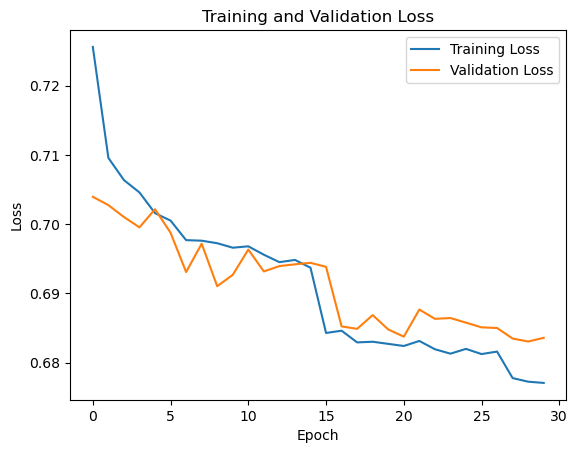

In [97]:
# Plot the training and validation losses
plt.plot(range(n_epochs), train_losses, label='Training Loss')
plt.plot(range(n_epochs), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.xticks(range(n_epochs)+1)
# plt.xlim(0, n_epochs-1)
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


[0.09465183 0.13606589 0.2685102  ... 0.02675794 0.5271223  0.17779918]


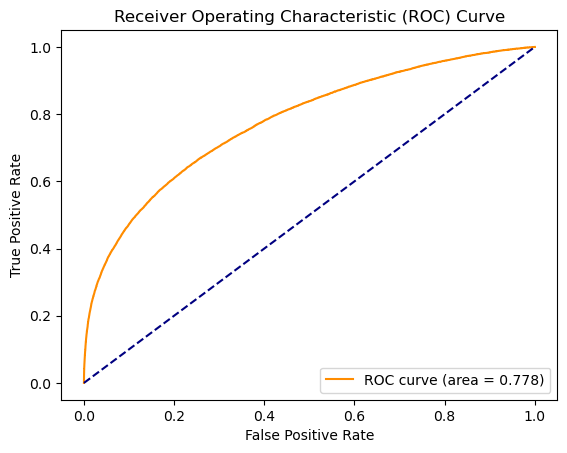

In [98]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Collect all predictions and true labels
all_outputs = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # Get model outputs (logits if using BCEWithLogitsLoss)
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility
        all_outputs.extend(probs)
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays
all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
print(all_outputs)
all_labels = np.array(all_labels)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_outputs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Diagonal line for random performance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


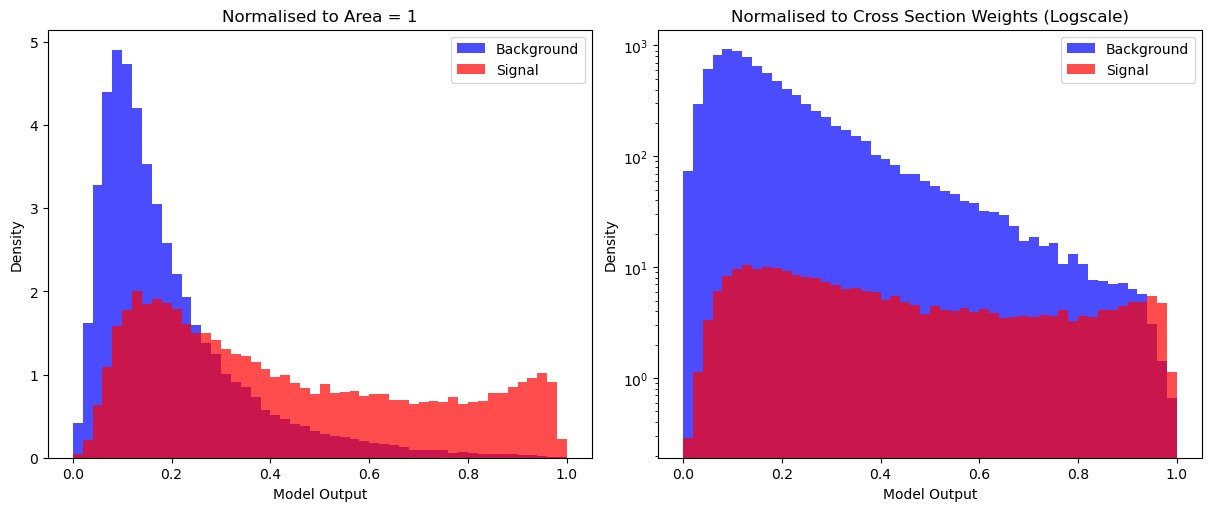

In [99]:
# Plot a hisogram of the model outputs for signal and background
model.eval()

# Collect all predictions and true labels

all_outputs = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # Get model outputs (logits if using BCEWithLogitsLoss)
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility
        all_outputs.extend(probs)
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels)

# Plot the model outputs for signal and background

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot 1: Normalized to Area = 1
axs[0].hist(all_outputs[all_labels == 0], bins=50, range=(0, 1), alpha=0.7, label='Background', density=True, color='b')
axs[0].hist(all_outputs[all_labels == 1], bins=50, range=(0, 1), alpha=0.7, label='Signal', density=True, color='r')
axs[0].set_xlabel('Model Output')
axs[0].set_ylabel('Density')
axs[0].set_title("Normalised to Area = 1")
# axs[1].set_xlim(0, 1
axs[0].legend()

# Plot 2: Normalized to Cross Section Weights (Logscaled)
axs[1].hist(all_outputs[all_labels == 0], bins=50, range=(0, 1), alpha=0.7, label='Background', weights=wn_test[all_labels == 0]*200000, color='b')
axs[1].hist(all_outputs[all_labels == 1], bins=50, range=(0, 1), alpha=0.7, label='Signal', weights=wn_test[all_labels == 1]*200000, color='r')
axs[1].set_xlabel('Model Output')
axs[1].set_ylabel('Density')
axs[1].set_title("Normalised to Cross Section Weights (Logscale)")
axs[1].set_yscale('log')
# axs[1].set_xlim(0, 1)
axs[1].legend()

plt.show()

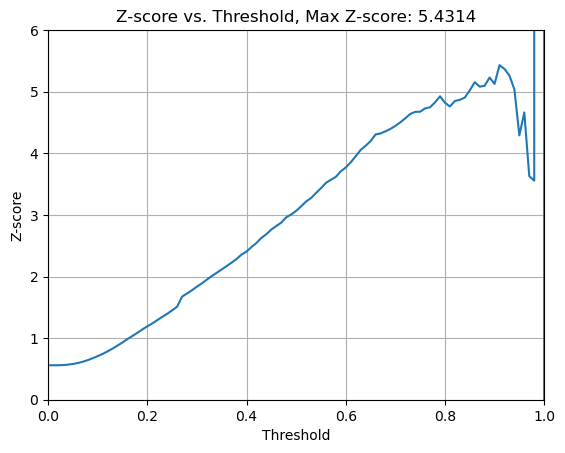

In [93]:
# Assume w_test is the array of weights for each sample in the test set
wn_test_array = np.array(wn_test*200000)

# Define thresholds between 0 and 1
thresholds = np.linspace(0, 1, 101)
z_scores = []

# Calculate the Z-score for each threshold using weights
for threshold in thresholds:
    # Weighted count of signal predictions above the threshold
    S = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 1)])  # Weighted Signal
    B = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 0)])  # Weighted Background
    sig_B = B * 0.05 # 5% error
    
    Z = S / np.sqrt(B + sig_B**2 + 1e-10)

    z_scores.append(Z)

# Plot Z-score vs. Threshold
plt.plot(thresholds, z_scores, label="Z-score")
plt.xlabel("Threshold")
plt.ylabel("Z-score")
plt.title(f"Z-score vs. Threshold, Max Z-score: {max(z_scores[:95]):.4f}")
plt.grid()
plt.ylim(0,6)
plt.xlim(0,1)
plt.show()

print()